In [45]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import gutenberg
nltk.download('gutenberg')
import re
from sklearn.model_selection import train_test_split


%matplotlib inline

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\gyans\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


In [94]:
#reading in the data, this time in the form of paragraphs
emma=gutenberg.paras('austen-emma.txt')
#processing
emma_paras=[]
for paragraph in emma:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    emma_paras.append(' '.join(para))

print(emma_paras[0:4])

['[ Emma by Jane Austen 1816 ]', 'VOLUME I', 'CHAPTER I', 'Emma Woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to unite some of the best blessings of existence ; and had lived nearly twenty - one years in the world with very little to distress or vex her .']


In [95]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test = train_test_split(emma_paras, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
min_df=2, # only use words that appear at least twice
stop_words='english', 
lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
use_idf=True,#we definitely want to use inverse document frequencies in our weighting
norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  
 #Prevents divide-by-zero errors
                            )


#Applying the vectorizer
emma_paras_tfidf=vectorizer.fit_transform(emma_paras)
print("Number of features: %d" % emma_paras_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 1948
Original sentence: A very few minutes more , however , completed the present trial .
Tf_idf vector: {'minutes': 0.71274503103825837, 'present': 0.70142321085794701}


In [48]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])




Percent variance captured by all components: 45.2103629886
Component 0:
" Oh !     0.99929
" Oh !"    0.99929
" Oh !     0.99929
" Oh !     0.99929
" Oh !     0.99929
" Oh !     0.99929
" Oh !     0.99929
" Oh !     0.99929
" Oh !     0.99929
" Oh !     0.99929
Name: 0, dtype: float64
Component 1:
" You have made her too tall , Emma ," said Mr . Knightley .                                                                                                                0.634571
" You get upon delicate subjects , Emma ," said Mrs . Weston smiling ; " remember that I am here . Mr .                                                                     0.590955
" You are right , Mrs . Weston ," said Mr . Knightley warmly , " Miss Fairfax is as capable as any of us of forming a just opinion of Mrs . Elton .                         0.562907
" I do not know what your opinion may be , Mrs . Weston ," said Mr . Knightley , " of this great intimacy between Emma and Harriet Smith , but I think it a ba

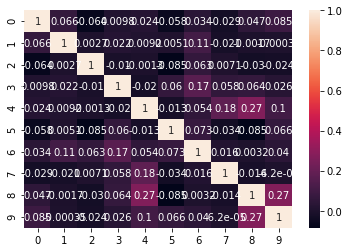

Key:
0 That is _court_ .
1 " Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me ."
2 " How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .
3 To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up  her hand seized  her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping  fearing  adoring  ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on being

In [97]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10), annot = True)
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])


# Drill 0

In [49]:
#Reshapes the vectorizer output into something people can read
X_test_tfidf_csr = X_test_tfidf.tocsr()

#number of paragraphs
n = X_test_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_test_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_test_tfidf_csr[i, j]



X_test_lsa = lsa.fit_transform(X_test_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_test_lsa,index=X_test)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])




Percent variance captured by all components: 49.4148006838
Component 0:
" Oh !       0.99992
" Oh !       0.99992
" Oh !       0.99992
" Oh !       0.99992
" Oh !       0.99992
" Oh !       0.99992
" Oh no !    0.99992
" Oh !       0.99992
" Oh !       0.99992
" Oh !       0.99992
Name: 0, dtype: float64
Component 1:
" Well , Mrs . Weston ," said Emma triumphantly when he left them , " what do you say now to Mr . Knightley ' s marrying Jane Fairfax ?"                                                                                                                                                                                                                                                                                                             0.614421
After tea , Mr . and Mrs . Weston , and Mr . Elton sat down with Mr . Woodhouse to cards .                                                                                                                                                 

# Conclusion

Component 0 is the same, targeting 'Oh!'

Component 1 is different, dialogue about other characters, particularly Mr . and Mrs prefixes.

Component 2 is targeting 'Ah!' whereas previously, it was captured as Component 3

Component 4 is different, targeting 'yes'

# Drill 1 - Tweaking tf-idf

In [38]:
print('Decreased Max_df to 0.3 ')
vectorizer = TfidfVectorizer(max_df=0.3, # drop words in more than 30% of paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

Decreased Max_df to 0.3 


In [39]:
def apply_vectorizer():

    emma_paras_tfidf=vectorizer.fit_transform(emma_paras)
    print("Number of features: %d" % emma_paras_tfidf.get_shape()[1])
    X_train_tfidf, X_test_tfidf= train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)

    X_train_tfidf_csr = X_train_tfidf.tocsr()

    n = X_train_tfidf_csr.shape[0]

    tfidf_bypara = [{} for _ in range(0,n)]

    terms = vectorizer.get_feature_names()

    for i, j in zip(*X_train_tfidf_csr.nonzero()):
        tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

        
    svd= TruncatedSVD(130)
    lsa = make_pipeline(svd, Normalizer(copy=False))

    # Run SVD on the training data, then project the training data.
    X_train_lsa = lsa.fit_transform(X_train_tfidf)

    variance_explained=svd.explained_variance_ratio_
    total_variance = variance_explained.sum()
    print("Percent variance captured by all components:",total_variance*100)

In [40]:
apply_vectorizer()

Number of features: 1948
Percent variance captured by all components: 45.1964425795


Variance stayed pretty much the same with a drop in max_df. Let's try some other changes.

In [41]:
print('increased min_df to 10 with max_df = 0.3')
vectorizer = TfidfVectorizer(max_df= 0.3, # drop words in more than 30% of paragraphs
                             min_df= 10, # only use words that appear at least 10 times
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

increased min_df to 10 with max_df = 0.3


In [42]:
apply_vectorizer()

Number of features: 382
Percent variance captured by all components: 69.3431585756


Variance increased to around 69%. This also decreased the number of features in the space.

In [43]:
print('Changed correction factor to L1')
vectorizer = TfidfVectorizer(max_df= 0.3, # drop words in more than 30% of paragraphs
                             min_df= 10, # only use words that appear at least 10 times
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l1', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

Changed correction factor to L1


In [44]:
apply_vectorizer()

Number of features: 382
Percent variance captured by all components: 79.1767040344


this increased the variance explained by the model, to 79%.

Little clean up

In [98]:
#reading in the data, this time in the form of paragraphs
emma=gutenberg.paras('austen-emma.txt')
#processing
emma_paras=[]
for paragraph in emma:
    para=paragraph[0]
    #removing the double-dash from all words
    para = [re.sub(r'--','',word) for word in para]
    
    #Forming each paragraph into a string and adding it to the list of strings.
    emma_paras.append(' '.join(para))

print(emma_paras[0:4])
print()
emma_paras2 = []
for para in emma_paras:
    para = re.sub(r'CHAPTER \D+','',para) 
    para = re.sub(r'VOLUME \D+','',para) 
    para = re.sub("[\[].*?[\]]", "", para)
    emma_paras2.append(''.join(para))
print(emma_paras2[0:4])

['[ Emma by Jane Austen 1816 ]', 'VOLUME I', 'CHAPTER I', 'Emma Woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to unite some of the best blessings of existence ; and had lived nearly twenty - one years in the world with very little to distress or vex her .']

['', '', '', 'Emma Woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to unite some of the best blessings of existence ; and had lived nearly twenty - one years in the world with very little to distress or vex her .']


In [99]:
import spacy
nlp = spacy.load('en')

#emma_paras is a list. spacy needs to take in string inputs in order to parse, so input the strings 1 at a time from the list

emma_spacy = []
for para in emma_paras2: 
    emma_spacy.append(nlp(para))

In [100]:
emma_spacy_2 = []

for para in emma_spacy:
    sp = [token.lemma_
                for token in para
                if not token.is_punct
                and not token.is_stop]
    
    emma_spacy_2.append(' '.join(sp))


In [101]:
#Just view some example sentence and make sure the lemmas worked as expected
print('Actual')
print(emma_paras2[0:4])
print('After spacy')
print(emma_spacy_2[0:4])



Actual
['', '', '', 'Emma Woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to unite some of the best blessings of existence ; and had lived nearly twenty - one years in the world with very little to distress or vex her .']
After spacy
['', '', '', 'emma woodhouse handsome clever and rich with a comfortable home and happy disposition seem to unite some of the good blessing of existence and have live nearly twenty one year in the world with very little to distress or vex -PRON-']


Now divide the lemmas into a train and test set, vectorize, create a new singular value decomposition, and normalize

In [102]:
X_train, X_test = train_test_split(emma_spacy_2, test_size=0.4, random_state=0)

In [106]:
from sklearn.pipeline import Pipeline

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

svd_model = TruncatedSVD(n_components=130)


svd_transformer = Pipeline([('tfidf', vectorizer), 
                            ('svd', svd_model),
                            ('norm', Normalizer(copy=False))])

svd_matrix = svd_transformer.fit_transform(X_train)

#Create separate dataframe for the test rows
paras_train = pd.DataFrame(X_train_lsa, index = X_train)

#Print test components and the top 10 highest scoring rows (paragraphs)
for i in range (5):
    print("Component {}:".format(i))
    print(paras_train.loc[:, i].sort_values(ascending = False)[0:10])

Component 0:
oh    0.99929
oh    0.99929
oh    0.99929
oh    0.99929
oh    0.99929
oh    0.99929
oh    0.99929
oh    0.99929
oh    0.99929
oh    0.99929
Name: 0, dtype: float64
Component 1:
-PRON- have make -PRON- too tall emma say mr knightley                                                                                                                 0.634571
-PRON- get upon delicate subject emma say mrs weston smile remember that -PRON- be here mr                                                                             0.590955
-PRON- be right mrs weston say mr knightley warmly miss fairfax be as capable as any of -PRON- of form a just opinion of mrs elton                                     0.562907
-PRON- do not know what -PRON- opinion may be mrs weston say mr knightley of this great intimacy between emma and harriet smith but -PRON- think -PRON- a bad thing    0.562677
there be misunderstanding between -PRON- emma -PRON- say so expressly                                     

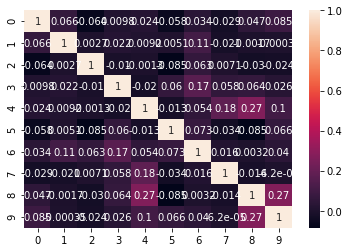

Key:
0 that be court
1 yes sir -PRON- do indeed and -PRON- be very much oblige by -PRON- kind solicitude about -PRON-
2 how much -PRON- business engross -PRON- already be very plain from the circumstance of -PRON- forgetting to inquire for the book -PRON- recommend
3 to restrain -PRON- as much as may be by -PRON- own manner -PRON- be immediately prepare to speak with exquisite calmness and gravity of the weather and the night but scarcely have -PRON- begin scarcely have -PRON- pass the sweep gate and join the other carriage than -PRON- find -PRON- subject cut up   -PRON- hand seize   -PRON- attention demand and mr elton actually make violent love to -PRON- avail -PRON- of the precious opportunity declare sentiment which must be already well know hop   fear   adore   ready to die if -PRON- refuse -PRON- but flatter -PRON- that -PRON- ardent attachment and unequalled love and unexampled passion could not fail of have some effect and in short very much resolve on be seriously accept as so

In [105]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10), annot = True)
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])

# Conclusion

Variance stayed pretty much the same with a drop in max_df (Decreased Max_df to 0.3 from 0.5)

When increased min_df to 10 from 2, with max_df = 0.3 - Variance increased to around 69%. This also decreased the number of features in the space.

When Changed correction factor to L1 with min_df as 10 and max_df as 0.3, this increased the variance explained by the model to 79%.